<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on the GPU
Files already downloaded and verified
Files already downloaded and verified


  2%|▏         | 25/1407 [00:00<00:05, 249.29it/s]

datasets loaded


  2%|▏         | 23/1407 [00:00<00:06, 223.04it/s]

epoch: 0, loss: 2.11940860748291


100%|██████████| 1407/1407 [00:12<00:00, 110.09it/s]

epoch: 1, loss: 2.0442230701446533


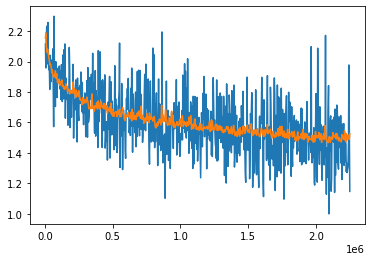

[[486  24  79   6  55  22 124  44 139  21]
 [ 95 321  23  16  20  17 147  38 163 160]
 [181  16 292  40  71  55 244  48  42  11]
 [111  19 115 118  81 158 249  60  49  40]
 [170  21 173  18 206  52 233  73  45   9]
 [ 96  15 128  82  58 289 210  70  36  16]
 [ 87  19  81  30  57  43 591  43  29  20]
 [153  16  97  32  81  53 112 370  45  41]
 [241  68  34  15  28  34  68  34 432  46]
 [ 90 117  29  21  15  19 125  85 138 361]]
Accuracy of the network on the 10000 test images: 34.66
281.182861328125
0.48026177287101746
57.528602600097656
1.3342187404632568


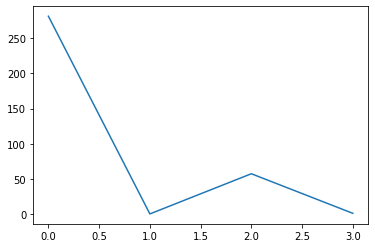

In [31]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

np.random.seed(1)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = datasets.CIFAR10("./", train=True, transform=transform_list, download=True)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

'''for data in train:
  X, y = data[0][0], data[1][0]
  plt.imshow(X.view(32, 32))
  print("Label: " + str(y))
  plt.show()
  break'''

class LogisticRegression(nn.Module):
  
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(LogisticRegression, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.relu(self.linear1(x))
    out = self.linear2(out)
    return out


def test_perform(test_data):
  total = 0
  correct = 0

  y_true = []
  y_pred = []

  loss = 0.0
  i=0
  with torch.no_grad():
    for data in test_data:
      X, y = data[0].to(device), data[1].to(device)

      output = model(X.view(-1, IMG_SIZE))
      _, predicted = torch.max(output, 1)

      loss += criterion(output, y)

      total += y.size(0)
      correct += (predicted == y).sum().item()

      y_pred.extend(predicted.tolist())
      y_true.extend(y.tolist())

      i+=1

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred, loss/i


def train_perform(args):
  learning_rate, hidden_dim = args
  model = LogisticRegression(IMG_SIZE, 10, hidden_dim).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss().to(device)

  BATCH_SIZE = 32

  loss_train = []
  loss_val = []
  iter_list = []
  iter_num = 0

  for epoch in range(2):
    train_size = int(0.9 * len(train))
    val_size = len(train) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

    for data in tqdm(train_loader):
      X, y = data[0].to(device), data[1].to(device)
      
      optimizer.zero_grad()
      
      output = model(X.view(-1, IMG_SIZE))
      
      loss = criterion(output, y)
      
      loss.backward()
      
      optimizer.step()
      
      iter_num+=BATCH_SIZE

      if(iter_num%(BATCH_SIZE*100) == 0):
        _, _, _, val_loss = test_perform(val_loader)

        iter_list.append(iter_num)
        loss_train.append(loss)
        loss_val.append(val_loss)

      
    print(f'epoch: {epoch}, loss: {loss}')
  return sum(loss_val).item()

train_perform((0.001, 100))

plt.plot(iter_list, loss_train)
plt.plot(iter_list, loss_val)
plt.show()

    
accuracy, y_true, y_pred, _ = test_perform(test)

print(confusion_matrix(y_true, y_pred))
print(f'Accuracy of the network on the 10000 test images: {accuracy}')

norm_list = []
for x in model.parameters():
  print(x.grad.cpu().norm(1).tolist())
  norm_list.append(x.grad.cpu().norm(1).tolist())

plt.plot(norm_list)
plt.show()

In [33]:
from hyperopt import hp, tpe, fmin

space = [hp.uniform('learning_rate', 0.001, 0.005), hp.choice('hidden_dim', [200, 250, 300])]
best = fmin(train_perform, space, algo=tpe.suggest, max_evals=3)
print(best)

  0%|          | 0/3 [00:00<?, ?it/s, best loss: ?]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 23/1407 [00:00<00:06, 228.48it/s]

  3%|3         | 47/1407 [00:00<00:05, 231.67it/s]

  5%|5         | 72/1407 [00:00<00:05, 234.85it/s]

  7%|6         | 95/1407 [00:00<00:05, 233.31it/s]

  8%|8         | 113/1407 [00:00<00:16, 78.42it/s]

 10%|9         | 137/1407 [00:01<00:12, 98.19it/s]

 12%|#1        | 162/1407 [00:01<00:10, 119.69it/s]

 13%|#3        | 187/1407 [00:01<00:08, 141.16it/s]

 15%|#4        | 208/1407 [00:01<00:16, 74.68it/s] 

 17%|#6        | 233/1407 [00:01<00:12, 94.40it/s]

 18%|#8        | 258/1407 [00:02<00:09, 115.56it/s]

 20%|##        | 282/1407 [00:02<00:08, 136.82it/s]

 22%|##1       | 304/1407 [00:02<00:14, 75.75it/s] 

 23%|##3       | 329/1407 [00:02<00:11, 95.37it/s]

 25%|##5       | 354/1407 [00:02<00:09, 116.53it/s]

 27%|##6       | 375/1407 [00:03<00:07, 133.60it/s]

 28%|##8       | 399/1407 [00:03<00:06, 153.12it/s]

 30%|##9       | 421/1407 [00:03<00:12, 78.58it/s] 

 32%|###1   

epoch: 0, loss: 1.5683904886245728
  0%|          | 0/3 [00:12<?, ?it/s, best loss: ?]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 25/1407 [00:00<00:05, 244.84it/s]

  4%|3         | 50/1407 [00:00<00:05, 243.86it/s]

  5%|5         | 75/1407 [00:00<00:05, 244.12it/s]

  7%|6         | 93/1407 [00:00<00:16, 80.87it/s] 

  8%|8         | 118/1407 [00:00<00:12, 100.76it/s]

 10%|#         | 141/1407 [00:01<00:10, 121.15it/s]

 12%|#1        | 165/1407 [00:01<00:08, 142.20it/s]

 14%|#3        | 190/1407 [00:01<00:07, 162.22it/s]

 15%|#4        | 211/1407 [00:01<00:15, 78.28it/s] 

 17%|#6        | 236/1407 [00:01<00:11, 98.35it/s]

 18%|#8        | 257/1407 [00:02<00:09, 116.36it/s]

 20%|##        | 282/1407 [00:02<00:08, 138.11it/s]

 22%|##1       | 303/1407 [00:02<00:14, 74.70it/s] 

 23%|##3       | 327/1407 [00:02<00:11, 94.08it/s]

 25%|##5       | 352/1407 [00:02<00:09, 115.41it/s]

 27%|##6       | 375/1407 [00:03<00:07, 135.53it/s]

 28%|##8       | 396/1407 [00:03<00:13, 74.37it/s] 

 30%|##9       | 420/1407 [00:03<00:10, 93.38it/s]

 32%|###1  

epoch: 1, loss: 1.8784724473953247
 33%|███▎      | 1/3 [00:25<00:51, 25.90s/it, best loss: 50.362945556640625]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 25/1407 [00:00<00:05, 248.76it/s]

  3%|3         | 47/1407 [00:00<00:05, 238.79it/s]

  5%|4         | 70/1407 [00:00<00:05, 234.86it/s]

  7%|6         | 94/1407 [00:00<00:05, 235.48it/s]

  8%|7         | 112/1407 [00:00<00:16, 79.51it/s]

 10%|9         | 136/1407 [00:01<00:12, 99.46it/s]

 11%|#1        | 161/1407 [00:01<00:10, 121.21it/s]

 13%|#3        | 184/1407 [00:01<00:08, 140.55it/s]

 14%|#4        | 204/1407 [00:01<00:16, 73.00it/s] 

 16%|#6        | 226/1407 [00:01<00:12, 91.13it/s]

 18%|#7        | 251/1407 [00:02<00:10, 112.36it/s]

 20%|#9        | 276/1407 [00:02<00:08, 134.36it/s]

 21%|##1       | 300/1407 [00:02<00:13, 79.15it/s] 

 23%|##3       | 324/1407 [00:02<00:10, 98.75it/s]

 25%|##4       | 349/1407 [00:02<00:08, 120.08it/s]

 27%|##6       | 374/1407 [00:03<00:07, 141.73it/s]

 28%|##8       | 398/1407 [00:03<00:06, 161.07it/s]

 30%|##9       | 421/1407 [00:03<00:12, 80.87it/s] 

 31%|###1   

epoch: 0, loss: 2.538721799850464
 33%|███▎      | 1/3 [00:38<00:51, 25.90s/it, best loss: 50.362945556640625]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 25/1407 [00:00<00:05, 243.89it/s]

  4%|3         | 50/1407 [00:00<00:05, 243.65it/s]

  5%|5         | 75/1407 [00:00<00:05, 242.62it/s]

  7%|6         | 93/1407 [00:00<00:16, 77.97it/s] 

  8%|8         | 115/1407 [00:01<00:13, 96.53it/s]

 10%|9         | 140/1407 [00:01<00:10, 117.70it/s]

 12%|#1        | 165/1407 [00:01<00:08, 139.49it/s]

 13%|#3        | 188/1407 [00:01<00:07, 157.88it/s]

 15%|#4        | 209/1407 [00:01<00:15, 77.51it/s] 

 17%|#6        | 233/1407 [00:02<00:12, 97.18it/s]

 18%|#8        | 258/1407 [00:02<00:09, 118.65it/s]

 20%|##        | 283/1407 [00:02<00:08, 140.02it/s]

 22%|##1       | 305/1407 [00:02<00:14, 76.57it/s] 

 23%|##3       | 329/1407 [00:02<00:11, 96.00it/s]

 25%|##5       | 353/1407 [00:03<00:09, 117.06it/s]

 27%|##6       | 376/1407 [00:03<00:07, 136.65it/s]

 28%|##8       | 397/1407 [00:03<00:13, 74.56it/s] 

 30%|##9       | 421/1407 [00:03<00:10, 93.63it/s]

 32%|###1   

epoch: 1, loss: 1.857767105102539
 67%|██████▋   | 2/3 [00:52<00:25, 25.98s/it, best loss: 50.362945556640625]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 25/1407 [00:00<00:05, 246.62it/s]

  3%|3         | 49/1407 [00:00<00:05, 243.40it/s]

  5%|5         | 74/1407 [00:00<00:05, 243.59it/s]

  7%|7         | 99/1407 [00:00<00:05, 242.95it/s]

  8%|8         | 118/1407 [00:00<00:15, 82.54it/s]

 10%|#         | 142/1407 [00:01<00:12, 102.72it/s]

 12%|#1        | 167/1407 [00:01<00:09, 124.57it/s]

 14%|#3        | 192/1407 [00:01<00:08, 146.38it/s]

 15%|#5        | 213/1407 [00:01<00:15, 74.77it/s] 

 17%|#6        | 238/1407 [00:01<00:12, 94.49it/s]

 19%|#8        | 263/1407 [00:02<00:09, 115.76it/s]

 20%|##        | 287/1407 [00:02<00:08, 136.53it/s]

 22%|##1       | 309/1407 [00:02<00:14, 76.13it/s] 

 24%|##3       | 334/1407 [00:02<00:11, 95.95it/s]

 25%|##5       | 358/1407 [00:02<00:08, 116.58it/s]

 27%|##7       | 382/1407 [00:03<00:07, 137.57it/s]

 29%|##8       | 404/1407 [00:03<00:13, 76.98it/s] 

 30%|###       | 427/1407 [00:03<00:10, 95.82it/s]

 32%|###2   

epoch: 0, loss: 2.2289421558380127
 67%|██████▋   | 2/3 [01:05<00:25, 25.98s/it, best loss: 50.362945556640625]

  0%|          | 0/1407 [00:00<?, ?it/s]

  2%|1         | 24/1407 [00:00<00:05, 231.65it/s]

  3%|3         | 48/1407 [00:00<00:05, 233.86it/s]

  5%|4         | 70/1407 [00:00<00:05, 228.37it/s]

  7%|6         | 93/1407 [00:00<00:14, 89.86it/s] 

  8%|8         | 115/1407 [00:01<00:11, 109.21it/s]

 10%|9         | 140/1407 [00:01<00:09, 130.75it/s]

 12%|#1        | 165/1407 [00:01<00:08, 151.71it/s]

 13%|#3        | 189/1407 [00:01<00:07, 169.63it/s]

 15%|#4        | 210/1407 [00:01<00:15, 79.43it/s] 

 17%|#6        | 233/1407 [00:02<00:11, 98.55it/s]

 18%|#8        | 258/1407 [00:02<00:09, 119.98it/s]

 20%|##        | 283/1407 [00:02<00:07, 141.47it/s]

 22%|##1       | 305/1407 [00:02<00:14, 75.82it/s] 

 23%|##3       | 327/1407 [00:02<00:11, 94.17it/s]

 25%|##4       | 351/1407 [00:03<00:09, 114.52it/s]

 27%|##6       | 375/1407 [00:03<00:07, 135.33it/s]

 28%|##8       | 396/1407 [00:03<00:13, 74.25it/s] 

 30%|##9       | 420/1407 [00:03<00:10, 93.65it/s]

 31%|###1  

epoch: 1, loss: 1.6347390413284302
100%|██████████| 3/3 [01:18<00:00, 26.04s/it, best loss: 50.279136657714844]
{'hidden_dim': 2, 'learning_rate': 0.0033337192520570503}
